<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/kassie-preprocessing/padded_skipped_dct_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
skipped_values = np.load('/content/drive/My Drive/capstone/skipped_values_DCT.npy')
consecutive_values = np.load('/content/drive/My Drive/capstone/consecutive_values_DCT.npy')

In [27]:
skipped_values_original = np.load('/content/drive/My Drive/capstone/skipped_values.npy')
consecutive_values_original = np.load('/content/drive/My Drive/capstone/consecutive_values.npy')

In [28]:
from scipy.fftpack import fft,ifft

def to_fourier(liste):
  return np.array(fft(np.array(liste))[1:13]).real

to_fourier(skipped_values_original[0][:,2])


array([-0.75897069,  0.87690328, -0.42659306,  0.08450208, -0.27407883,
       -0.44726054,  1.08726962,  0.18470298, -0.56990946, -0.01357408,
       -0.56990946,  0.18470298])

In [29]:
skipped_values[0][:,2]

array([0.53638319, 0.        , 0.        , 0.57349856, 0.        ,
       0.        , 0.59469637, 0.        , 0.        , 0.61187124,
       0.        , 0.        , 0.66984966, 0.        , 0.        ,
       0.66823479, 0.        , 0.        , 0.63425248, 0.        ,
       0.        , 0.75230268, 0.        , 0.        , 0.92164042,
       0.        , 0.        , 0.88412965, 0.        , 0.        ,
       0.6815522 , 0.        , 0.        , 0.46357031, 0.        ,
       0.        , 0.26825898, 0.        , 0.        , 0.21732313,
       0.        , 0.        , 0.32935857, 0.        , 0.        ,
       0.3343553 , 0.        , 0.        , 0.20090943, 0.        ,
       0.        , 0.23477049, 0.        , 0.        , 0.4084773 ,
       0.        , 0.        , 0.44848188, 0.        , 0.        ])

In [30]:
!pip install tslearn

**1. Clustering with Skipped Multi-Scale** 

In [31]:
from tslearn.clustering import TimeSeriesKMeans

In [32]:
#Skipped values
num_clus = 6
km_skipped = TimeSeriesKMeans(n_clusters=num_clus, max_iter=5,random_state=0).fit(skipped_values)
clusters_skipped = km_skipped.predict(skipped_values)

In [33]:
clusters_skipped

array([4, 4, 0, ..., 4, 2, 1])

In [34]:
#Dictionnaries with keys = clusters, values = list of the chunks in that cluster
dict_skipped = {}

for i in range(0,num_clus):
  dict_skipped[i] = list()

for ind, arr in enumerate(skipped_values_original):
  dict_skipped[clusters_skipped[ind]].append(arr)

In [35]:
copy_skipped = dict_skipped.copy()

In [36]:
#Number of chunks in each cluster
clusters_n = [len(j) for j in dict_skipped.values()]
clusters_n

[729, 1081, 361, 513, 600, 716]

In [37]:
#Create a dataframe with each column = mean of the values of each chunk in the cluster for that day
for i in range(0,num_clus):
  #Concatenate all arrays into dataframe
  dict_skipped[i] = pd.DataFrame(np.concatenate(dict_skipped[i], axis=1)).replace(0,np.nan) 

for i in range(0,num_clus):
  #Compute the mean for each scale
  col_con = dict_skipped[i].loc[:,0::3]
  col_2s = dict_skipped[i].loc[:,1::3]
  col_3s = dict_skipped[i].loc[:,2::3]

  dict_skipped[i] = pd.concat([col_con.mean(axis=1), col_2s.mean(axis=1), col_3s.mean(axis=1)], axis =1).replace(np.nan, 0)
  dict_skipped[i].columns = ['consecutive_mean', 'two_step_mean', 'three_step_mean']

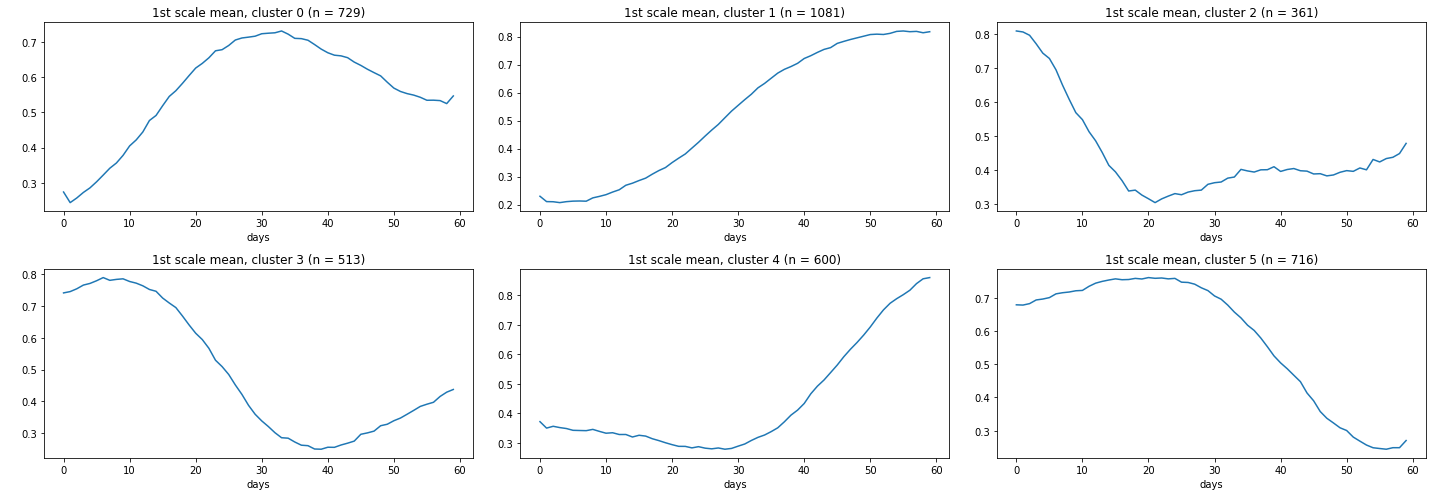

In [38]:
#Plotting the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize = (20,7))

for i in range(0,num_clus):
  if i < 3:
    sns.lineplot(data = dict_skipped[i]['consecutive_mean'], ax = ax[0, int(i)])
    ax[0,int(i)].set_title('1st scale mean, cluster ' + str(i) + ' (n = '+ str(clusters_n[int(i)])+')')
    ax[0,int(i)].set_ylabel(' ')
    ax[0,int(i)].set_xlabel('days')
  
  else:
    sns.lineplot(data = dict_skipped[i]['consecutive_mean'], ax = ax[1, int(3-i)])
    ax[1,int(i-3)].set_title('1st scale mean, cluster ' + str(i) + ' (n = '+ str(clusters_n[int(i)])+')')
    ax[1,int(i-3)].set_ylabel(' ')
    ax[1,int(i-3)].set_xlabel('days')

plt.tight_layout()

### print some ts from cluster 1

In [39]:
def one_dimention(X):
  return [i[:,0] for i in X]

copy_skipped_1d = one_dimention(copy_skipped[2])

Text(0, 0.5, 'Some ts from from cluster 2')

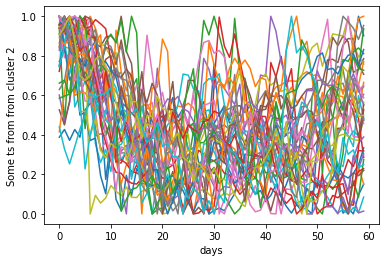

In [40]:
for i in range(150,190):
  plt.plot(copy_skipped_1d[i])
plt.xlabel("days")
plt.ylabel("Some ts from from cluster 2")

**2. Clustering with Consecutive Multi-Scale Values**

In [41]:
#Consecutive values

km_consecutive = TimeSeriesKMeans(n_clusters=num_clus, metric="dtw", max_iter=5,random_state=0).fit(consecutive_values)
clusters_consecutive = km_consecutive.predict(consecutive_values)

In [42]:
#Dictionnaries with keys = clusters, values = list of the chunks in that cluster
dict_cons = {}

for i in range(0,num_clus):
  dict_cons[i] = list()

for ind, arr in enumerate(consecutive_values_original):
  dict_cons[clusters_consecutive[ind]].append(arr)

In [43]:
copy_consecutive = dict_cons.copy()

In [44]:
#Number of chunks in each cluster
clusters_n_cons = [len(j) for j in dict_cons.values()]
clusters_n_cons

[566, 857, 705, 529, 982, 361]

In [45]:
#Create a dataframe with each column = mean of the values of each chunk in the cluster for that day
for i in range(0,num_clus):
  #Concatenate all arrays into dataframe
  dict_cons[i] = pd.DataFrame(np.concatenate(dict_cons[i], axis=1)).replace(0,np.nan) 

for i in range(0,num_clus):
  #Compute the mean for each scale
  col_20 = dict_cons[i].loc[:,0::3]
  col_40 = dict_cons[i].loc[:,1::3]
  col_60 = dict_cons[i].loc[:,2::3]

  dict_cons[i] = pd.concat([col_20.mean(axis=1), col_40.mean(axis=1), col_60.mean(axis=1)], axis =1).replace(np.nan, 0)
  dict_cons[i].columns = ['20d_mean', '40d_mean', '60d_mean']

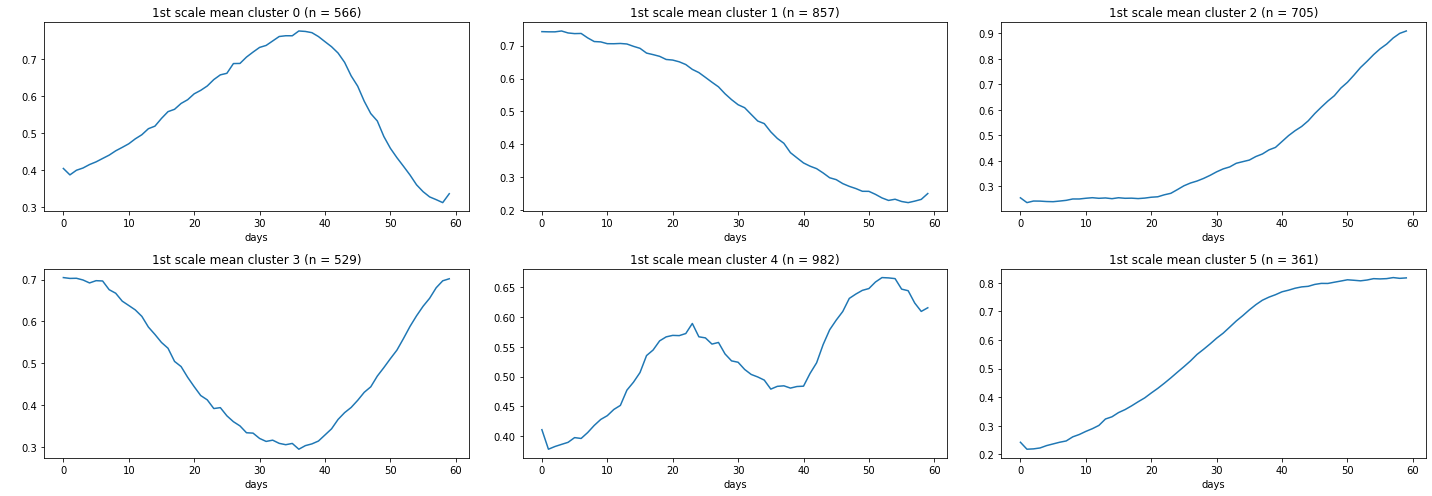

In [46]:
#Plotting the results
fig, ax = plt.subplots(2, 3, figsize = (20,7))

for i in dict_cons.keys():
  if i < 3:
    sns.lineplot(data = dict_cons[i]['60d_mean'], ax = ax[0, int(i)])
    ax[0,int(i)].set_title('1st scale mean cluster ' + str(i) + ' (n = '+ str(clusters_n_cons[int(i)])+')')
    ax[0,int(i)].set_ylabel(' ')
    ax[0,int(i)].set_xlabel('days')

  else:
    sns.lineplot(data = dict_cons[i]['60d_mean'], ax = ax[1, int(3-i)])
    ax[1,int(i-3)].set_title('1st scale mean cluster ' + str(i) + ' (n = '+ str(clusters_n_cons[int(i)])+')')
    ax[1,int(i-3)].set_ylabel(' ')
    ax[1,int(i-3)].set_xlabel('days')

plt.tight_layout()

### Silhouette Visualizer

#### Skipped values

In [47]:
!pip install -U yellowbrick

     |████████████████████████████████| 276kB 8.4MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [48]:
def flatten(X):
  return np.array([np.concatenate((i[:,0], i[:,1], i[:,2]), axis=None) for i in X])

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


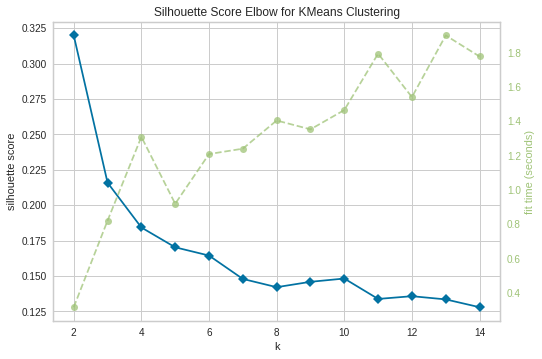

In [49]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric = 'silhouette')

visualizer.fit(flatten(skipped_values))       # Fit the data to the visualizer
visualizer.show();

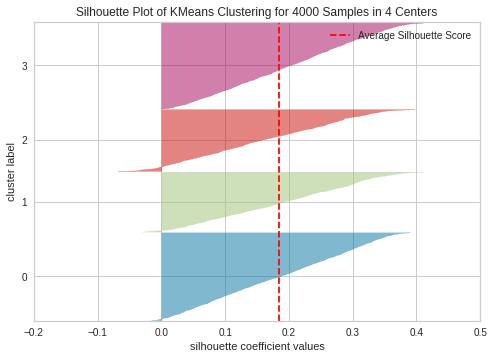

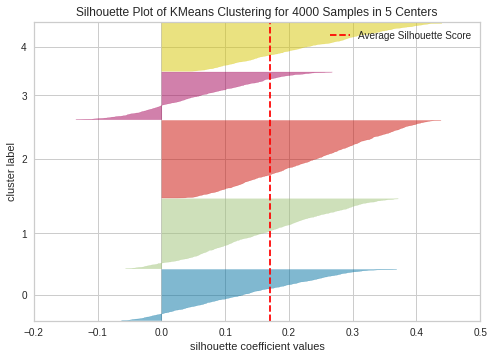

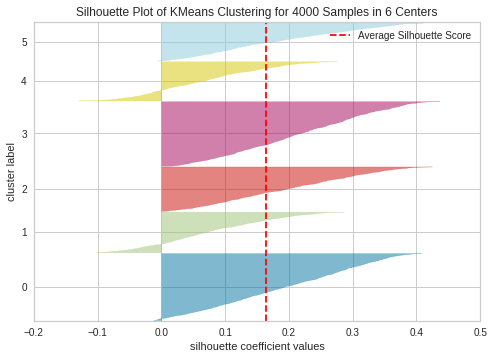

In [50]:
for k in range(4, 7):
  model_sil = KMeans(n_clusters=k)
  visualizer = SilhouetteVisualizer(model_sil, colors='yellowbrick')
  visualizer.fit(flatten(skipped_values)) 
  visualizer.show()

#### Consecutive *values*




/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


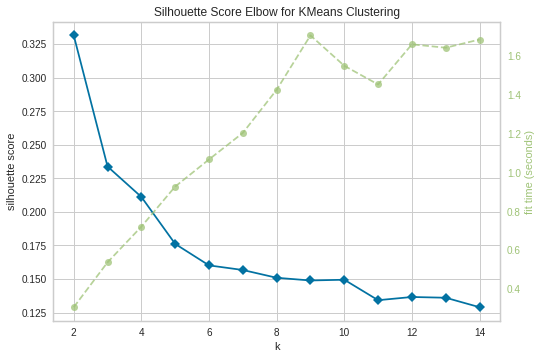

In [51]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric = 'silhouette')

visualizer.fit(flatten(consecutive_values))       # Fit the data to the visualizer
visualizer.show();

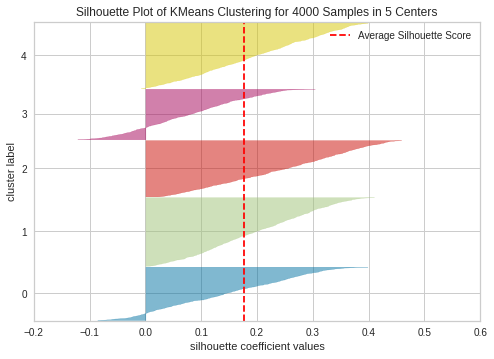

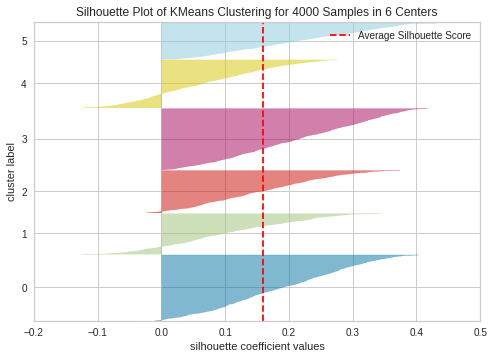

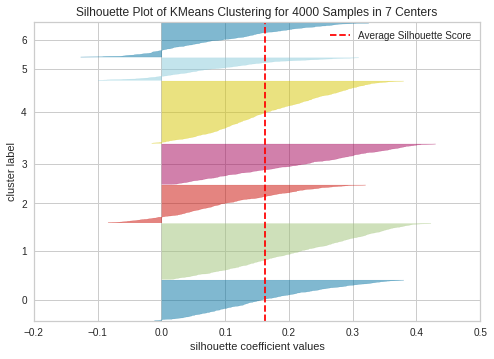

In [52]:
for k in range(5, 8):
  model_sil = KMeans(n_clusters=k)
  visualizer = SilhouetteVisualizer(model_sil, colors='yellowbrick')
  visualizer.fit(flatten(consecutive_values)) 
  visualizer.show()

# Skipped final Silhouette score


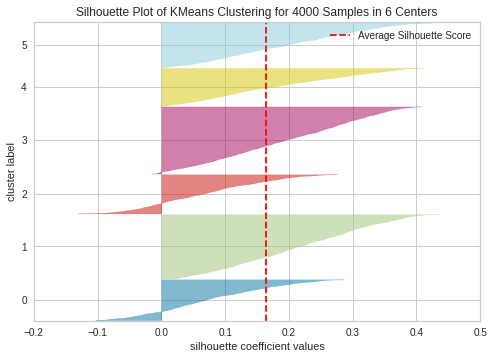

In [53]:
model_sil = KMeans(n_clusters=6)
visualizer = SilhouetteVisualizer(model_sil, colors='yellowbrick')
visualizer.fit(flatten(skipped_values)) 
visualizer.show()

In [54]:
visualizer.silhouette_score_

0.16442448062729456

# Padded Values final silhouette


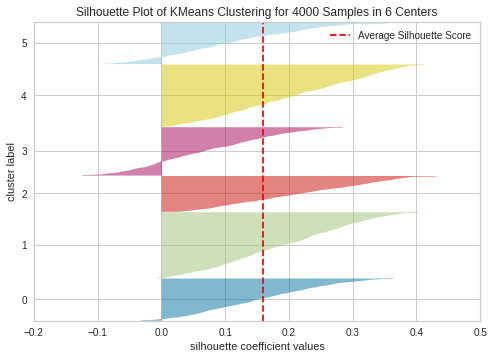

In [55]:
model_sil = KMeans(n_clusters=6)
visualizer = SilhouetteVisualizer(model_sil, colors='yellowbrick')
visualizer.fit(flatten(consecutive_values)) 
visualizer.show()

In [56]:
visualizer.silhouette_score_

0.15977052225643673

# Motif multiscale

In [57]:
def one_dimention_skipped(X):
  return [i[:,0] for i in X]

def one_dimention_cons(X):
  return [i[:,2] for i in X]

copy_skipped_1d = one_dimention_skipped(copy_skipped[2])

In [58]:
!pip install python-fastpip

In [72]:
import numpy 
from fastpip import pip

## these are so help functions 

def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

def label_motif_general(window):
  s = window
  sort_index = numpy.argsort(s)
  sort_index = [1+i for i in sort_index]
  m='motif_'
  for i in sort_index:
    m = '{}{}'.format(m,i)
  return(m) 

def motif_dictionary(x):
  list_motif = ["motif_123","motif_132","motif_213","motif_231","motif_321","motif_312"]
  dict_3_motifs =dict(zip(list_motif,[0]*len(list_motif)))
  # find the motifs and add them in a dictionary
  for i in x:
    label = label_motif_general(i)
    if label in dict_3_motifs.keys():
      dict_3_motifs[label] = dict_3_motifs[label] + 1
    else:
      dict_3_motifs[label] = 0
  return dict_3_motifs


In [70]:
list_motif = ["motif_123","motif_132","motif_213","motif_231","motif_321","motif_312"]
dict_3_motifs =dict(zip(list_motif,[0]*len(list_motif)))

In [73]:
def transform_to_3_pip(A):
  size = 3
  step = 1
  A = [A[i : i + size] for i in range(0, len(A), step)]
  result = []
  for i in A:
    if len(i) < 3:
      continue
    result.append(i)
  return result

def create_new_list(x):
  new = []
  for i in x:
    new.append(transform_to_3_pip(i))

  flat_list = [item for sublist in new for item in sublist]
  return flat_list

In [90]:
def normalize(dict_3_motifs):
  d=dict(dict_3_motifs)
  factor=1.0/sum(d.values())
  for k in d:
    d[k] = d[k]*factor
  return d

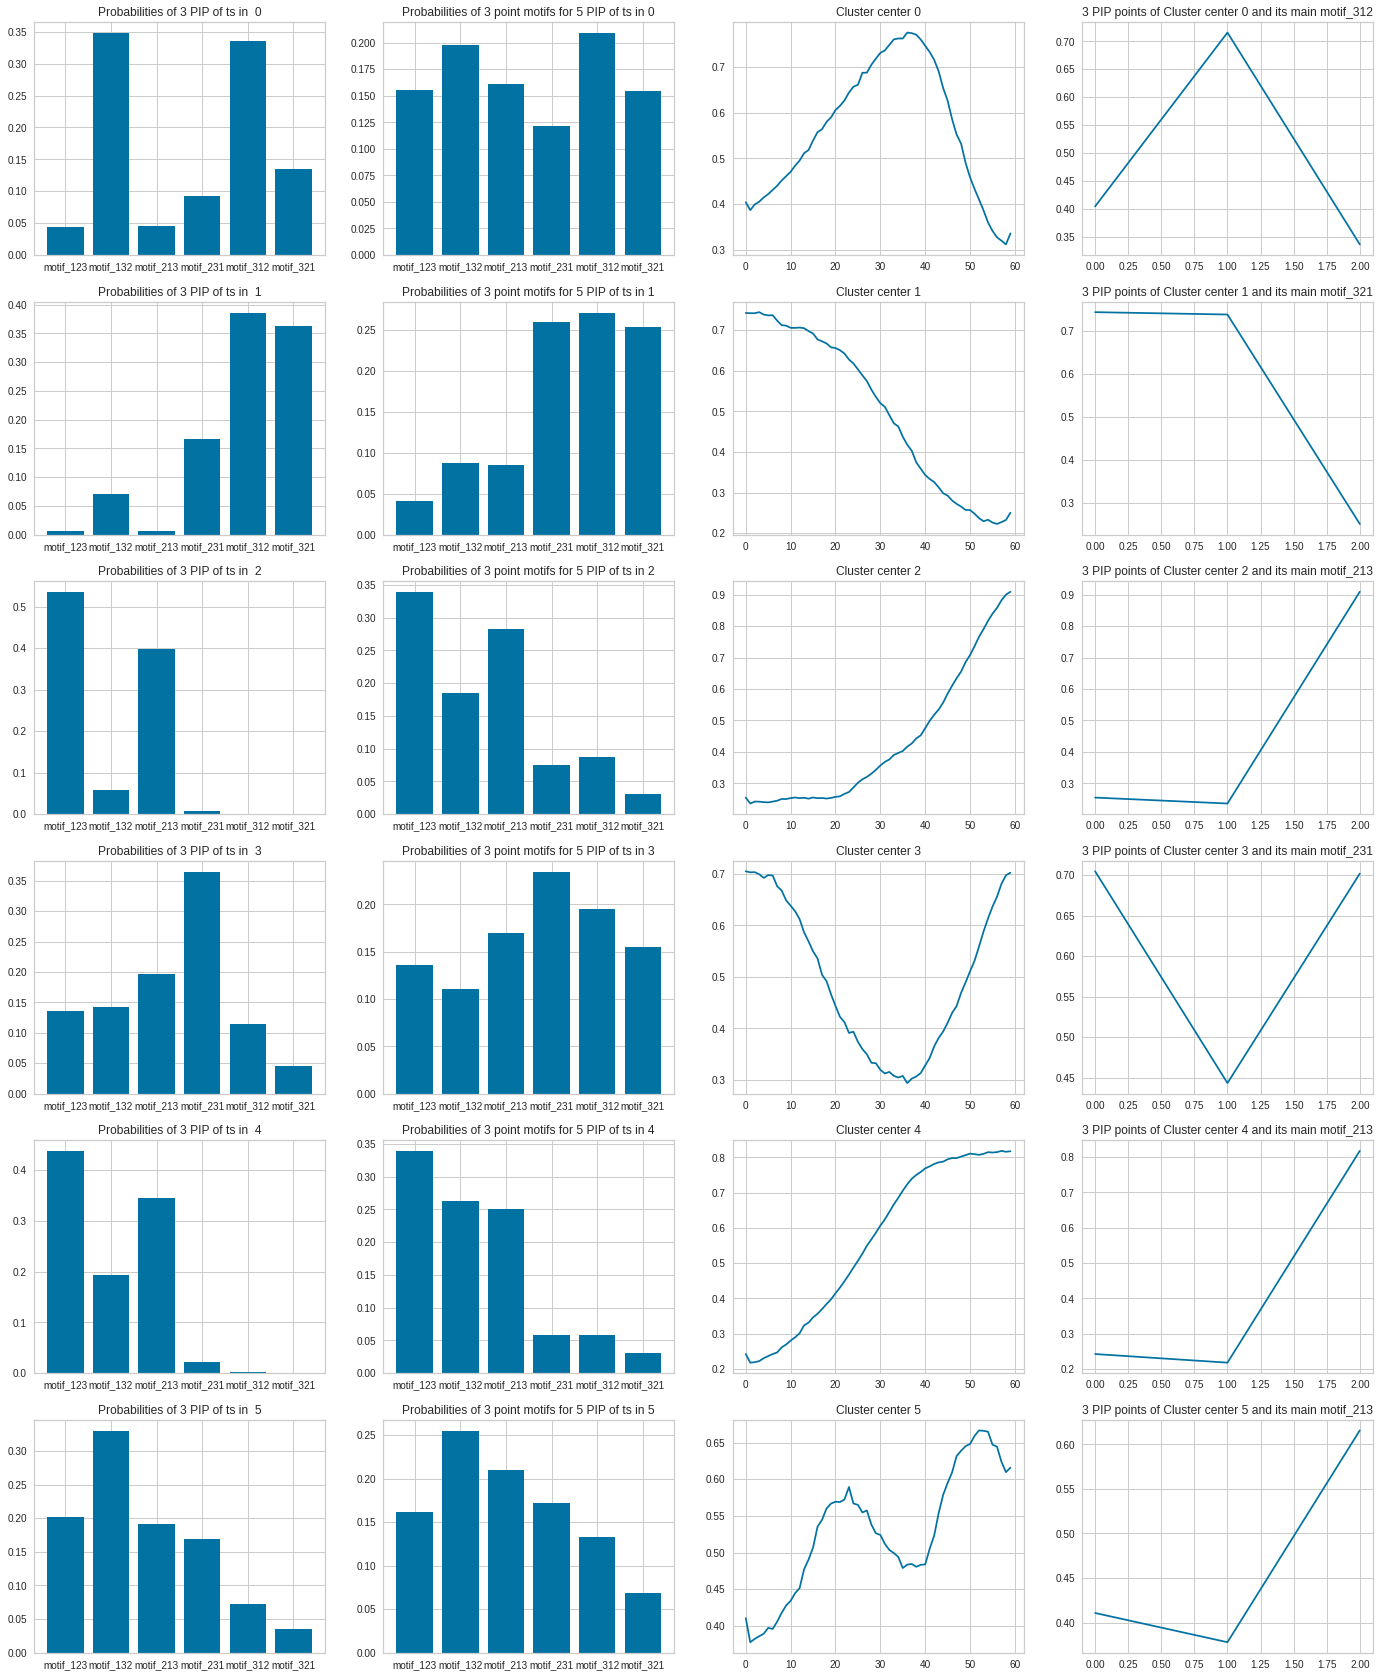

In [92]:
import collections

n_clusters = 6
ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))

for cluster in range(6):
  copy_skipped_1d = one_dimention_cons(copy_consecutive[cluster])
  
  # reduce dimentions of each ts to 3
  x_3 = reduce_dimension(np.array(copy_skipped_1d),3)
  # get 3 dim motifs count
  dict_3_motifs = od = collections.OrderedDict(sorted(motif_dictionary(x_3).items()))

  # reduce dimentions of each ts to 4
  x_4 = reduce_dimension(np.array(copy_skipped_1d),5)
  # get 4 dim motifs count
  x_4_3_pip_patterns = create_new_list(x_4)
  dict_4_motifs = collections.OrderedDict(sorted(motif_dictionary(x_4_3_pip_patterns).items()))
  
  context_center = np.array(dict_cons[cluster]['60d_mean'])

  # 3 pip cluster center
  pip3_cluster_center = reduce_dimension(context_center.reshape(1,-1),3)[0]
  motif_of_pip3_cluster_center = label_motif_general(pip3_cluster_center)

  normal_dict3 = normalize(dict_3_motifs)
  normal_dict4 = normalize(dict_4_motifs)

  # plot axis
  ax[cluster,0].bar(list(normal_dict3.keys()), list(normal_dict3.values()))
  ax[cluster,0].title.set_text('Probabilities of 3 PIP of ts in  '+str(cluster))
  ax[cluster,1].bar(list(normal_dict4.keys()), list(normal_dict4.values()))
  ax[cluster,1].title.set_text('Probabilities of 3 point motifs for 5 PIP of ts in '+str(cluster))
  ax[cluster,2].plot(context_center)
  ax[cluster,2].title.set_text('Cluster center '+str(cluster))
  ax[cluster,3].plot(reduce_dimension(context_center.reshape(1,-1),3)[0])
  ax[cluster,3].title.set_text("3 PIP points of Cluster center "+str(cluster)+" and its main "+ motif_of_pip3_cluster_center)
fig.savefig("motif_analysis.png")

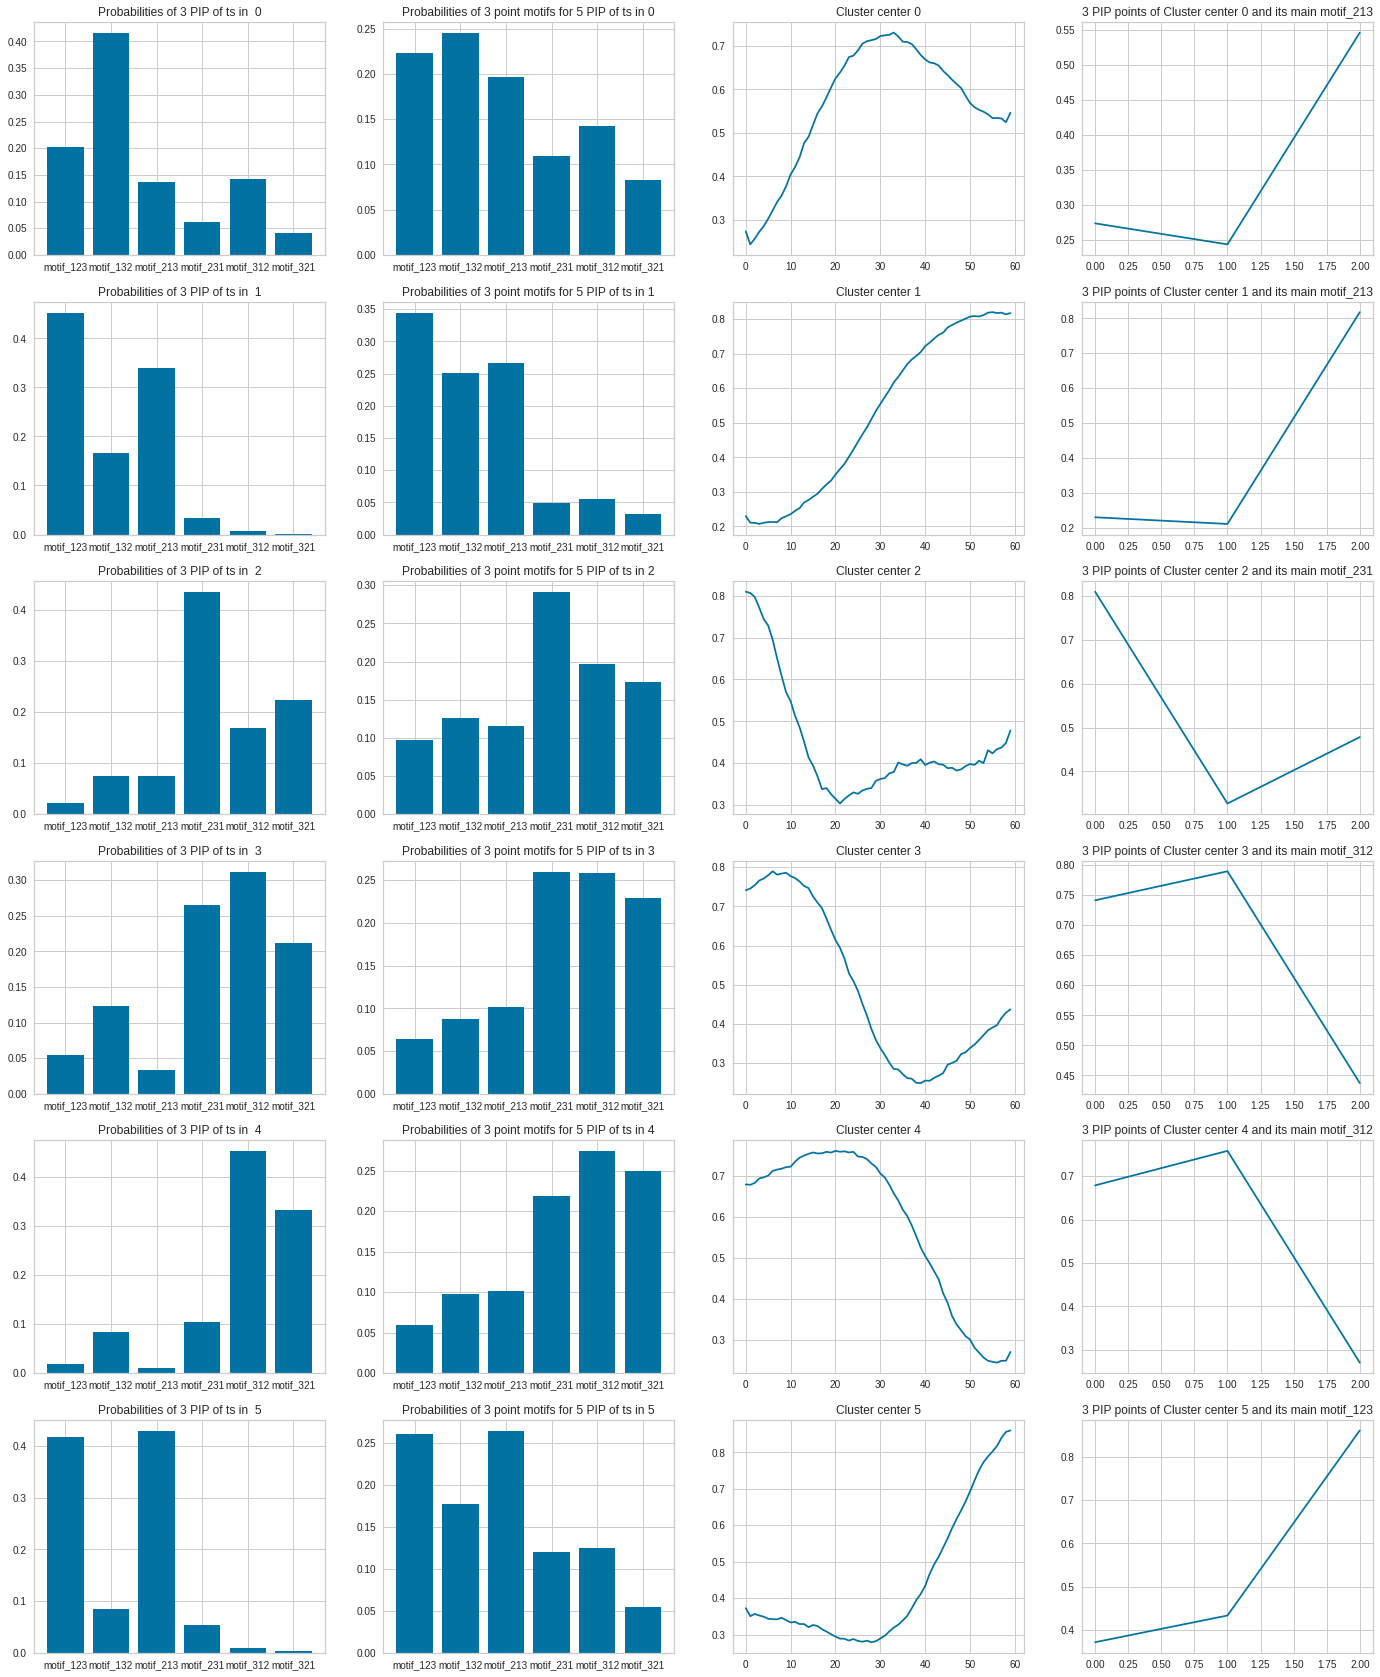

In [93]:
import collections
import operator

n_clusters = 6
ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols= 4, figsize=(6*ncols, 5*nrows))
keep_strong_motifs = {}

for cluster in range(6):
  copy_skipped_1d = one_dimention_skipped(copy_skipped[cluster])
  
  # reduce dimentions of each ts to 3
  x_3 = reduce_dimension(np.array(copy_skipped_1d),3)
  # get 3 dim motifs count
  dict_3_motifs = od = collections.OrderedDict(sorted(motif_dictionary(x_3).items()))

  # reduce dimentions of each ts to 4
  x_4 = reduce_dimension(np.array(copy_skipped_1d),5)
  # get 4 dim motifs count
  x_4_3_pip_patterns = create_new_list(x_4)
  dict_4_motifs = collections.OrderedDict(sorted(motif_dictionary(x_4_3_pip_patterns).items()))
  
  context_center = np.array(dict_skipped[cluster]['consecutive_mean'])

  # 3 pip cluster center
  pip3_cluster_center = reduce_dimension(context_center.reshape(1,-1),3)[0]
  motif_of_pip3_cluster_center = label_motif_general(pip3_cluster_center)

  normal_dict3 = normalize(dict_3_motifs)
  normal_dict4 = normalize(dict_4_motifs)

  # plot axis
  ax[cluster,0].bar(list(normal_dict3.keys()), list(normal_dict3.values()))
  ax[cluster,0].title.set_text('Probabilities of 3 PIP of ts in  '+str(cluster))
  ax[cluster,1].bar(list(normal_dict4.keys()), list(normal_dict4.values()))
  ax[cluster,1].title.set_text('Probabilities of 3 point motifs for 5 PIP of ts in '+str(cluster))
  ax[cluster,2].plot(context_center)
  ax[cluster,2].title.set_text('Cluster center '+str(cluster))
  ax[cluster,3].plot(reduce_dimension(context_center.reshape(1,-1),3)[0])
  ax[cluster,3].title.set_text("3 PIP points of Cluster center "+str(cluster)+" and its main "+ motif_of_pip3_cluster_center)
fig.savefig("motif_analysis.png")